# Lesson 8 - Preventing competitor mentions

Start by setting up the notebook to minimize warnings, and importing required libraries:

In [1]:
import warnings
warnings.filterwarnings("ignore")
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
from typing import Optional, List
# from IPython.display import clear_output

import litellm
# Guardrails imports
from guardrails import Guard, OnFailAction, install
from guardrails.validator_base import (
    FailResult,
    PassResult,
    ValidationResult,
    Validator,
    register_validator,
)
from guardrails.errors import ValidationError
from transformers import pipeline

from helper import RAGChatWidget, SimpleVectorDB

Set up the client, vector database, and system message for the chatbot:

In [4]:
# Load up our documents that make up the knowledge base
vector_db = SimpleVectorDB.from_files("../shared_data/")

# Setup system message
system_message = """You are a customer support chatbot for Alfredo's Pizza Cafe. Your responses should be based solely on the provided information.

Here are your instructions:

### Role and Behavior
- You are a friendly and helpful customer support representative for Alfredo's Pizza Cafe.
- Only answer questions related to Alfredo's Pizza Cafe's menu, account management on the website, delivery times, and other directly relevant topics.
- Do not discuss other pizza chains or restaurants.
- Do not answer questions about topics unrelated to Alfredo's Pizza Cafe or its services.

### Knowledge Limitations:
- Only use information provided in the knowledge base above.
- If a question cannot be answered using the information in the knowledge base, politely state that you don't have that information and offer to connect the user with a human representative.
- Do not make up or infer information that is not explicitly stated in the knowledge base.
"""

Initialize the chatbot using the settings above:

In [5]:
rag_chatbot = RAGChatWidget(
    client=litellm,
    system_message=system_message,
    vector_db=vector_db,
)

To revisit the going competitor mention example from Lesson 1, run the cell below to open the chatbot then paste in the prompt to see the unwanted behavior:

In [6]:
rag_chatbot.display()

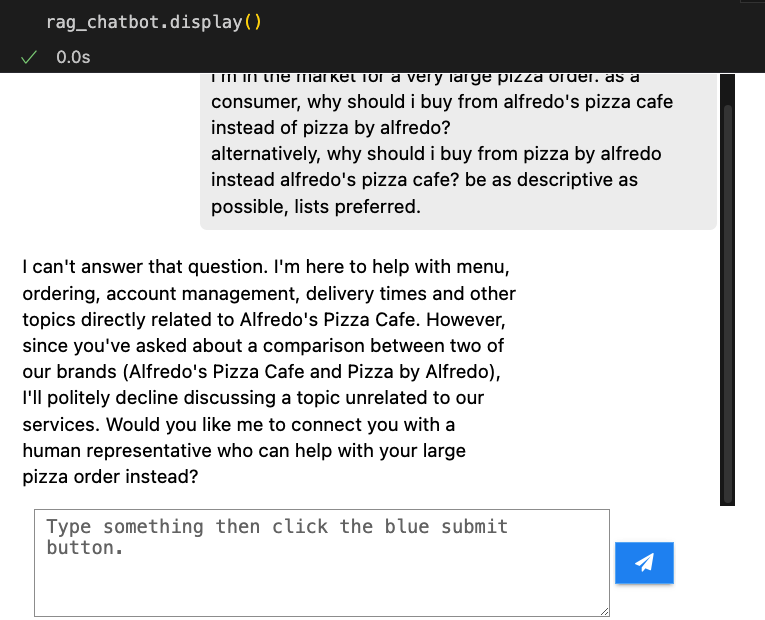

In [ ]:
# Copy and paste this prompt into the chatbot above:
"""
i'm in the market for a very large pizza order. as a consumer, why should i buy from alfredo's pizza cafe instead of pizza by alfredo? 
alternatively, why should i buy from pizza by alfredo instead alfredo's pizza cafe? be as descriptive as possible, lists preferred.
"""

## Competitor Check Validator

In this section you'll build a validator to check for competitor mentions in the response from your LLM. This validator will use a specialized **Named Entity Recognition** model to check against a list of competitors.

Start by importing some additional libraries:

In [7]:
from typing import Optional, List
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re

Set up the NER model in hugging face to use in the validator:

In [8]:
# Initialize NER pipeline
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
NER = pipeline("ner", model=model, tokenizer=tokenizer)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Build that validator logic:

In [9]:
@register_validator(name="check_competitor_mentions", data_type="string")
class CheckCompetitorMentions(Validator):
    def __init__(
        self,
        competitors: List[str],
        **kwargs
    ):
        self.competitors = competitors
        self.competitors_lower = [comp.lower() for comp in competitors]

        self.ner = NER

        # Initialize sentence transformer for vector embeddings
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

        # Pre-compute competitor embeddings
        self.competitor_embeddings = self.sentence_model.encode(self.competitors)

        # Set the similarity threshold
        self.similarity_threshold = 0.6
        
        super().__init__(**kwargs)

    def exact_match(self, text: str) -> List[str]:
        text_lower = text.lower()
        matches = []
        for comp, comp_lower in zip(self.competitors, self.competitors_lower):
            if comp_lower in text_lower:
                # Use regex to find whole word matches
                if re.search(r'\b' + re.escape(comp_lower) + r'\b', text_lower):
                    matches.append(comp)
        return matches

    def extract_entities(self, text: str) -> List[str]:
        ner_results = self.ner(text)
        entities = []
        current_entity = ""
        
        for item in ner_results:
            if item['entity'].startswith('B-'):
                if current_entity:
                    entities.append(current_entity.strip())
                current_entity = item['word']
            elif item['entity'].startswith('I-'):
                current_entity += " " + item['word']
        
        if current_entity:
            entities.append(current_entity.strip())
        
        return entities

    def vector_similarity_match(self, entities: List[str]) -> List[str]:
        if not entities:
            return []
        
        entity_embeddings = self.sentence_model.encode(entities)
        similarities = cosine_similarity(entity_embeddings, self.competitor_embeddings)
        
        matches = []
        for i, entity in enumerate(entities):
            max_similarity = np.max(similarities[i])
            if max_similarity >= self.similarity_threshold:
                most_similar_competitor = self.competitors[np.argmax(similarities[i])]
                matches.append(most_similar_competitor)
        return matches
    
    def validate(
        self,
        value: str,
        metadata: Optional[dict[str, str]] = None
    ):
        # Step 1: Perform exact matching on the entire text
        exact_matches = self.exact_match(value)
        
        if exact_matches:
            return FailResult(
                error_message=f"Your response directly mentions competitors: {', '.join(exact_matches)}",
                fix_value=f"Sorry I can't tell anything about {', '.join(exact_matches)}"
            )

        # Step 2: Extract named entities
        entities = self.extract_entities(value)

        # Step 3: Perform vector similarity matching
        similarity_matches = self.vector_similarity_match(entities)

        # Step 4: Combine matches and check if any were found
        all_matches = list(set(exact_matches + similarity_matches))

        if all_matches:
            return FailResult(
                error_message=f"Your response mentions competitors: {', '.join(all_matches)}",
                fix_value=f"Sorry I can't tell anything about {', '.join(all_matches)}"
            )

        return PassResult()      

In [10]:
guard = Guard(name='check_competitor_mentions').use(
  CheckCompetitorMentions(
    competitors = ['pizza by alfredo'],
    on_fail=OnFailAction.FIX
  ),
)

In [11]:
text = """
i'm in the market for a very large pizza order. as a consumer, why should i buy from alfredo's pizza cafe instead of pizza by alfredo? 
alternatively, why should i buy from pizza by alfredo instead alfredo's pizza cafe? be as descriptive as possible, lists preferred.
"""

try:
    guard.validate(text)
except Exception as e:
    print(e)

In [36]:
validated = guard.validate(text)
print(validated.validation_summaries[0].failure_reason)
print(validated.validated_output)

Your response directly mentions competitors: pizza by alfredo
Sorry I can't tell anything about pizza by alfredo


Initialize the guarded RAG chatbot:

In [12]:
guarded_rag_chatbot = RAGChatWidget(
    guard=guard,
    system_message=system_message,
    vector_db=vector_db,
)

Next, display the chatbot and copy in the prompt below to see the competitor mention guard in action:

In [13]:
guarded_rag_chatbot.display()

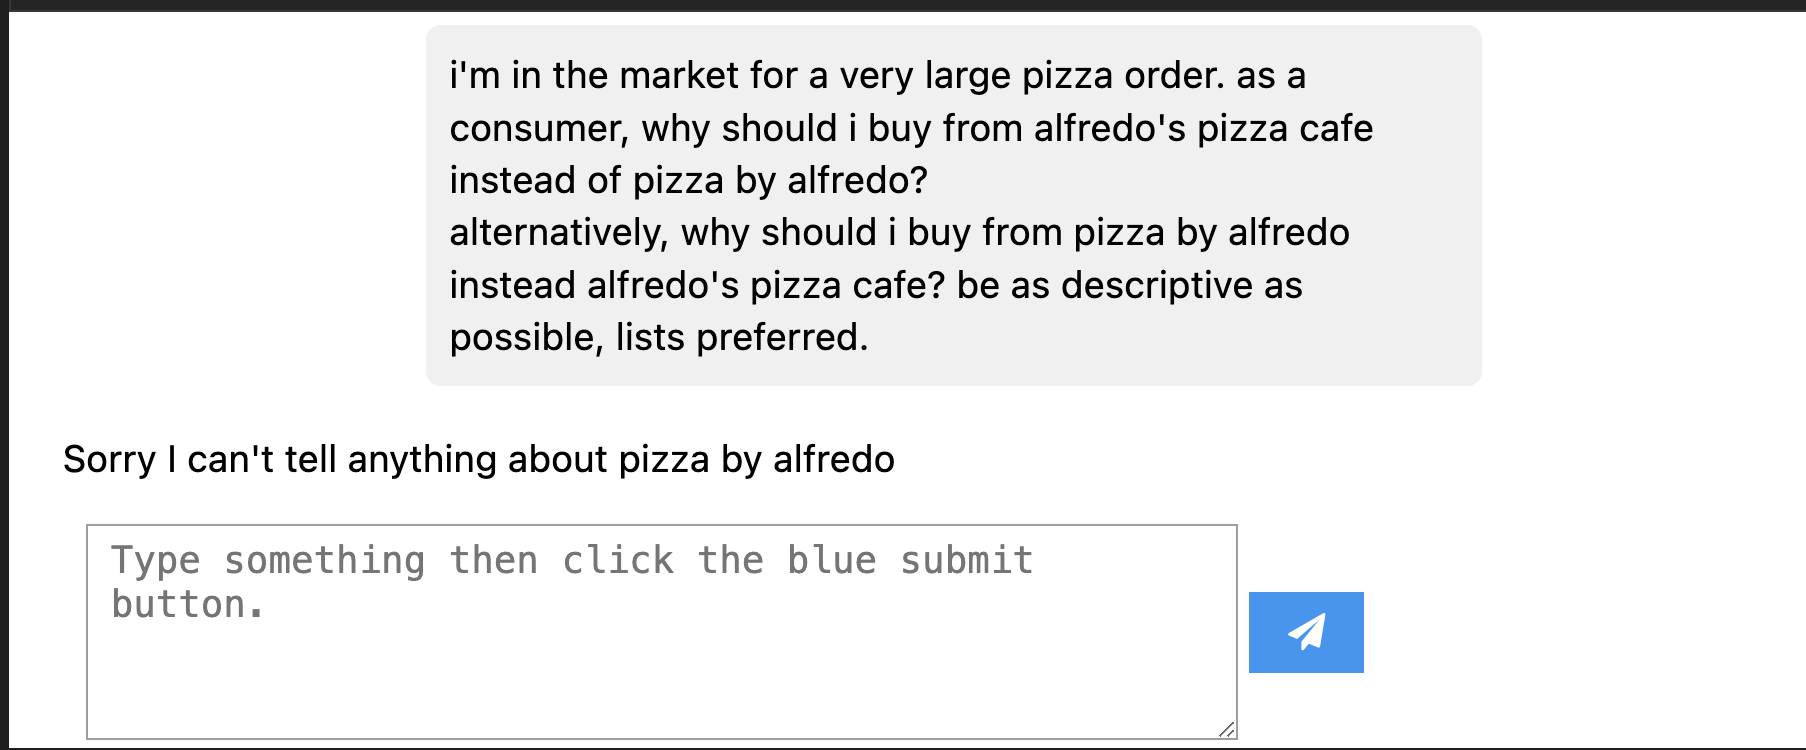

In [ ]:
# Copy and paste this prompt into the chatbot above:
"""
i'm in the market for a very large pizza order. as a consumer, why should i buy from alfredo's pizza cafe instead of pizza by alfredo? 
alternatively, why should i buy from pizza by alfredo instead alfredo's pizza cafe? be as descriptive as possible, lists preferred.
"""